<a href="https://colab.research.google.com/github/emmachenjz/emmachenjz/blob/main/TCAIREM_Teaching_Data_Science_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pipeline

The goal of this notebook is to learn about sklearn's pipeline and some useful data science tips.

[View in colab](https://colab.research.google.com/github/alistairewj/tree-prediction-tutorial/blob/master/pipeline_introduction.ipynb)

In [ ]:
# Import libraries
from datetime import timedelta
import collections
import os
import errno

import sklearn
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import datasets

import numpy as np
import pandas as pd
import pydotplus
import matplotlib
import matplotlib.pyplot as plt

# used to display trees
from IPython.display import Image

%matplotlib inline
plt.style.use('ggplot')

plt.rcParams.update({'font.size': 20})

In [ ]:
def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return matplotlib.colors.LinearSegmentedColormap('CustomMap', cdict)

def plot_model_pred_2d(mdl, X, y, cm=None, cbar=True, xlabel=None, ylabel=None):
    # look at the regions in a 2d plot
    # based on scikit-learn tutorial plot_iris.html

    # get minimum and maximum values
    x0_min = X[:, 0].min()
    x0_max = X[:, 0].max()
    x1_min = X[:, 1].min()
    x1_max = X[:, 1].max()

    xx, yy = np.meshgrid(np.linspace(x0_min, x0_max, 100),
                         np.linspace(x1_min, x1_max, 100))

    Z = mdl.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    if not cm:
        # custom colormap
        #e58139f9 - orange
        #399de5e0 - to blue
        s = list()

        lo = np.array(matplotlib.colors.to_rgb('#e5813900'))
        hi = np.array(matplotlib.colors.to_rgb('#399de5e0'))

        for i in range(255):
            s.append( list((hi-lo)*(float(i)/255)+lo) )
        cm = make_colormap(s)

    # plot the contour - colouring different regions
    cs = plt.contourf(xx, yy, Z, cmap=cm)

    # plot the individual data points - colouring by the *true* outcome
    color = y.ravel()
    plt.scatter(X[:, 0], X[:, 1], c=color, edgecolor='k', linewidth=2,
                marker='o', s=60, cmap=cm)

    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)
    plt.axis("tight")
    #plt.clim([-1.5,1.5])
    if cbar:
        plt.colorbar()

def create_graph(mdl, cmap=None, feat=None):
    # cmap is a colormap
    # e.g. cmap = matplotlib.cm.coolwarm( np.linspace(0.0, 1.0, 256, dtype=float) )
    tree_graph = tree.export_graphviz(mdl, out_file=None,
                             feature_names=feat,
                             filled=True, rounded=True)
    graph = pydotplus.graphviz.graph_from_dot_data(tree_graph)

    # get colormap
    if cmap:
        # remove transparency
        if cmap.shape[1]==4:
            cmap = cmap[:,0:2]

        nodes = graph.get_node_list()
        for node in nodes:
            if node.get_label():
                # get number of samples in group 1 and group 2
                num_samples = [int(ii) for ii in node.get_label().split('value = [')[1].split(']')[0].split(',')]

                # proportion that is class 2
                cm_value = float(num_samples[1]) / float(sum(num_samples))
                # convert to (R, G, B, alpha) tuple
                cm_value = matplotlib.cm.coolwarm(cm_value)
                cm_value = [int(np.ceil(255*x)) for x in cm_value]
                color = '#{:02x}{:02x}{:02x}'.format(cm_value[0], cm_value[1], cm_value[2])
                node.set_fillcolor(color)

    Image(graph.create_png())
    return graph

# Exercise

We'll practice using pipeline on a dataset acquired from patients admitted to intensive care units at the Beth Israel Deaconness Medical Center in Boston, MA. All patients in the cohort stayed for at least 48 hours, and the goal of the prediction task is to predict in-hospital mortality. This data is a subset of a publicly accessible ICU database: MIMIC. If you're interested, you can read more about MIMIC [here](https://mimic.physionet.org).
The particular dataset we are using is described in more detail here: http://physionet.org/challenge/2012/

The data is originally provided as a time series of observations for a number of variables, but to simplify the analysis, we've done some preprocessing to get a single row for each patient.
The following cell will check if the data is available here. If it's not, it will download it to the subfolder `data` in the same folder as this notebook.

The goal of this challenge was to predict mortality, i.e. whether a patient died in the hospital at the end of their stay.

In [ ]:
url = 'https://github.com/alistairewj/tree-prediction-tutorial/raw/master/data/PhysionetChallenge2012-set-a.csv.gz'
seta = pd.read_csv(url, sep=',', header=0, compression='gzip')
seta.set_index('recordid', inplace=True)
seta.head()

,SAPS-I,SOFA,Length_of_stay,Survival,In-hospital_death,Age,Gender,Height,Weight,CCU,...,SysABP_last,TroponinI_last,TroponinT_last,WBC_last,Weight_last,pH_last,MechVentStartTime,MechVentDuration,MechVentLast8Hour,UrineOutputSum
recordid,,,,,,,,,,,,,,,,,,,,,
132539,6,1,5,-1,0,54.0,0.0,NaN,NaN,0,...,NaN,NaN,NaN,9.4,NaN,NaN,NaN,NaN,NaN,NaN
132540,16,8,8,-1,0,76.0,1.0,175.3,76.0,0,...,103.0,NaN,NaN,13.3,81.6,7.37,71.0,360.0,0.0,5.0
132541,21,11,19,-1,0,44.0,0.0,NaN,56.7,0,...,126.0,NaN,NaN,6.2,56.7,7.47,617.0,2160.0,1.0,14.0
132543,7,1,9,575,0,68.0,1.0,180.3,84.6,0,...,NaN,NaN,NaN,7.9,84.6,NaN,NaN,NaN,NaN,NaN
132545,17,2,4,918,0,88.0,0.0,NaN,NaN,0,...,NaN,NaN,NaN,4.8,NaN,NaN,NaN,NaN,NaN,NaN


Above, we can see we have a few variables:

- SAPS-I
- SOFA
- Length_of_stay
- Survival
- In-hospital_death
- Age
- Gender
- Height
- Weight
- CCU
- ...

Q1: How would I understand what these variables mean?

A1: Look at the documentation! http://physionet.org/challenge/2012/

## Avoid data leakage

Our first step will be to really understand our data through EDA. We can look at all the columns. Since there's so many, we print 10 per row.

In [ ]:
# print all the columns
for i in range(0, len(seta.columns), 10):
  print(list(seta.columns[i:i+10]))

['SAPS-I', 'SOFA', 'Length_of_stay', 'Survival', 'In-hospital_death', 'Age', 'Gender', 'Height', 'Weight', 'CCU']
['CSRU', 'SICU', 'DiasABP_first', 'GCS_first', 'Glucose_first', 'HR_first', 'MAP_first', 'NIDiasABP_first', 'NIMAP_first', 'NISysABP_first']
['RespRate_first', 'SaO2_first', 'Temp_first', 'DiasABP_last', 'GCS_last', 'Glucose_last', 'HR_last', 'MAP_last', 'NIDiasABP_last', 'NIMAP_last']
['NISysABP_last', 'RespRate_last', 'SaO2_last', 'Temp_last', 'DiasABP_lowest', 'GCS_lowest', 'Glucose_lowest', 'HR_lowest', 'MAP_lowest', 'NIDiasABP_lowest']
['NIMAP_lowest', 'NISysABP_lowest', 'RespRate_lowest', 'SaO2_lowest', 'Temp_lowest', 'DiasABP_highest', 'GCS_highest', 'Glucose_highest', 'HR_highest', 'MAP_highest']
['NIDiasABP_highest', 'NIMAP_highest', 'NISysABP_highest', 'RespRate_highest', 'SaO2_highest', 'Temp_highest', 'DiasABP_median', 'GCS_median', 'Glucose_median', 'HR_median']
['MAP_median', 'NIDiasABP_median', 'NIMAP_median', 'NISysABP_median', 'RespRate_median', 'SaO2_media

Q2: Are there columns which would cause data leakage?

A2: Yes! We should not use the survival column for in-hospital mortality prediction.

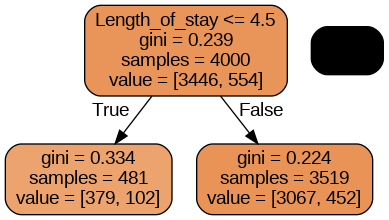

In [ ]:
# Alternative A2: We can see this with a decision tree.
mdl = ensemble.GradientBoostingClassifier(n_estimators=10)
X, y = seta[['Length_of_stay']].values, seta[['In-hospital_death']].values
mdl = tree.DecisionTreeClassifier(max_depth=1)
mdl = mdl.fit(X,y)
graph = create_graph(mdl, feat=['Length_of_stay'])
Image(graph.create_png())

In [ ]:
# remove cheating variables from training data
X = seta.drop(['In-hospital_death', 'Survival', 'Length_of_stay'], axis=1).values
features = list(seta.drop(['In-hospital_death', 'Survival', 'Length_of_stay'], axis=1).columns)
y = seta['In-hospital_death'].values

We are trying to build a machine learning model to predict an outcome. We would like this to work in the real world when we go out and use it. To do this, we need to estimate the *generalization* error of our model, which we approximate with the error on a set of data we have.

Q3: Why can't we just use the entire dataset to do this? That is, why can't we just do:

```python
model = train_model(data, target)
score = score_model(model, data, target)
print(f'My amazing score is: {score}!')
```

A3: Evaluating models on the same data they've been trained on is optimistic and misleading.

Models vary in their amount of flexibility (in statistics, we sometimes say models are high variance, which is somewhat confusing terminology). It can be helpful to imagine two extreme scenarios. Imagine our model always predicts the average of the outcome, which in this case is 15%:

```python
model = lambda x: return 0.15
```

Every time we ask the model to predict mortality for a patient, it returns 0.15. It doesn't matter what data we provide, this model won't overfit.

Now imagine a model that memorizes the data and returns the result it's already seen:

```python
model = lambda x: return target[x]
```

This model will perfectly predict our training set, but will do terribly on any external dataset.

For this reason, we hold out some data for evaluation.

In [ ]:
# here we only use the first 3000 observations as our training set
y_train = y[0:3000]
X_train = X[0:3000, :]

y_test = y[3000:]
X_test = X[3000:, :]

print('Training size: {} - {:6d} missing observations'.format(X_train.shape,
                                                           np.sum(np.sum(np.isnan(X_train)))))
print('Test size:     {} - {:6d} missing observations'.format(X_test.shape,
                                 np.sum(np.sum(np.isnan(X_test)))))

Training size: (3000, 116) -  87976 missing observations
Test size:     (1000, 116) -  29857 missing observations


## Missing data

The outcome is the first column `'In-hospital_death'`. Most of the rest of the data are features we can use to predict this binary outcome (while avoiding data leakage).

You'll note that the above has a lot of missing data! It is a challenging issue with medical data. In general there are three types of missing data:

1. Missing completely at random (MCAR)
    * The data is missing for reasons *unrelated* to the data
    * a power outage results in losing vital sign data
2. Missing at random (MAR)
    * The data is missing for reasons related to the data, but not the missing observation
    * we don't collect lactate measurements on admission to a medical ICU, but we collect them for cardiac ICU
3. Missing not at random (MNAR)
    * The data is missing, and the reason it is missing *depends* on the value
    * a doctor does not order the Troponin-I lab test, because they believe it to be normal

The hardest case to deal with is MNAR, and unfortunately, that is the most common in the medical domain. Still, we have to do something, so we often use approaches which are theoretically invalid under MNAR but in practice work acceptably well.

Below, we'll replace missing data with the average value for the training population.

In [ ]:
mu = np.nanmean(X, axis=0)
for i in range(5):
  print(f'{features[i]}: {mu[i]:2.1f}')

SAPS-I: 14.2
SOFA: 6.4
Age: 64.2
Gender: 0.6
Height: 172.0


Q4: What's wrong with the above approach?

In [ ]:
#A4: Data leakage! We use the test set values for estimating the mean.

# since decision trees do not handle missing data, we impute it here
mu = np.nanmean(X_train, axis=0)

for i in range(X_train.shape[1]):
    idxMissing = np.isnan(X_train[:, i])
    X_train[idxMissing, i] = mu[i]

    idxMissing = np.isnan(X_test[:, i])
    X_test[idxMissing, i] = mu[i]

# now we should find that we have no more missing data!

print('Training size: {} - {:6d} missing observations'.format(X_train.shape,
                                                           np.sum(np.sum(np.isnan(X_train)))))
print('Test size:     {} - {:6d} missing observations'.format(X_test.shape,
                                 np.sum(np.sum(np.isnan(X_test)))))

Training size: (3000, 116) -      0 missing observations
Test size:     (1000, 116) -      0 missing observations


## Idempotency

Q5: What's wrong with keeping the above code as is?

A5: I can very easily screw it all up by re-running everything out of order.

If working locally, this can be avoided by writing functions in a separate .py file, and using `%load_ext` and `%autoreload 2`.

In [ ]:
def prepare_dataset(seta):
  # remove cheating variables from training data
  X = seta.drop(['In-hospital_death', 'Survival', 'Length_of_stay'], axis=1).values
  y = seta['In-hospital_death'].values

  # here we only use the first 2500 observations as our training set
  y_train = y[0:2500]
  X_train = X[0:2500, :]

  y_test = y[2500:]
  X_test = X[2500:, :]

  features = list(seta.drop(['In-hospital_death', 'Survival', 'Length_of_stay'], axis=1).columns)

  return X_train, y_train, X_test, y_test, features

## Decision trees have high "variance"

It will be useful to demonstrate how decision trees have high "variance". In this context, variance refers to a property of some models to have a wide range of performance given random samples of data. Let's take a look at randomly slicing the data we have too see what that means.

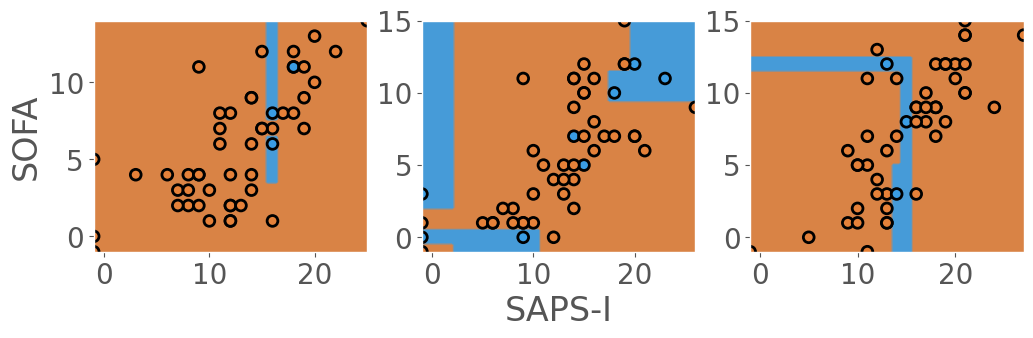

In [ ]:
np.random.seed(123)

fig = plt.figure(figsize=[12,3])
for i in range(3):
    ax = fig.add_subplot(1,3,i+1)

    # generate indices in a random order
    idx = np.random.permutation(X_train.shape[0])

    # only use the first 50
    idx = idx[:50]
    X_temp = X_train[idx, :2]
    y_temp = y_train[idx]

    # initialize the model
    mdl = tree.DecisionTreeClassifier(max_depth=5)

    # train the model using the dataset
    mdl = mdl.fit(X_temp, y_temp)

    # only specify labels once for clarity
    xlabel = features[0] if i == 1 else None
    ylabel = features[1] if i == 0 else None

    plot_model_pred_2d(mdl, X_temp, y_temp, xlabel=xlabel, ylabel=ylabel, cbar=False)

plt.show()

Above we can see that we are using random subsets of data, and as a result, our decision boundary can change quite a bit.

Let's build the model on the full training set.

In [ ]:
# Instantiate a decision tree classifier
mdl_dt = tree.DecisionTreeClassifier(criterion='entropy', splitter='best')

# Fit the model to the training data
mdl_dt = mdl_dt.fit(X_train, y_train)

# evaluate the model on the test set
yhat = mdl_dt.predict_proba(X_test)[:,1]
score = metrics.roc_auc_score(y_test, yhat)

print(f'Model AUROC on the test set: {score:1.3f}')

Model AUROC on the test set: 0.601


Q5: This was just one performance measure on a random 1000 cases. Are there techniques we can use to better evaluate how well this model would do on a held-out dataset?

A5: Of course :)

Cross-validation is a very common one.

## Improving the model

Let's say we wanted to improve this model, either by:

- doing cross-validation
- tuning hyperparameters
- changing the model type

We would have to be very careful about the data leakage step above, particularly with respect to missing data. We'd have to write for loops and constantly reshuffle the data around. This would be tedious, and very error prone.

Enter scikit-learn pipelines.

## Pipeline

A really great way of building models is to use `pipeline` from scikit-learn. This allows us to define the steps in our preprocessing *with* the ultimate model. It's a great feature that simplifies a lot of the tedium in preprocessing. Here's an example imputing missing data.

In [ ]:
# use pipeline to automatically apply preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression

# choose the classifier
base_mdl = tree.DecisionTreeClassifier(criterion='entropy', splitter='best')

# create a pipeline which imputes missing data, then runs the model
mdl = Pipeline(
    [
        ("preprocessor", SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('model', base_mdl)
    ]
)

# evaluate the model on the data - same as before!
mdl = mdl.fit(X_train, y_train)

# evaluate the model on the test set
yhat = mdl.predict_proba(X_test)[:, 1]
score = metrics.roc_auc_score(y_test, yhat)

print(f'Model AUROC on the test set: {score:1.3f}')

Model AUROC on the test set: 0.605


Now that we have a pipeline setup, we can actually use it with the original data, as our pipeline will impute the data for us. We can use another scikit-learn tool, cross_val_score, to evaluate the AUROC across cross-validation folds.

In [ ]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
scores = cross_val_score(mdl, X, y, cv=5, scoring='roc_auc')
print("AUROC: {:0.3f} [{:0.3f}, {:0.3f}]".format(np.mean(scores), np.min(scores), np.max(scores)))

AUROC: 0.598 [0.587, 0.615]


If we want to tune hyper-parameters, there is this helpful guide:
https://scikit-learn.org/stable/modules/grid_search.html#grid-search

Let's try to tune the max_depth parameter of our decision tree.

In [ ]:
from pprint import pprint
from sklearn.model_selection import GridSearchCV

param_grid = {'model__max_depth': [None, 3, 5, 10]}

grid_search = GridSearchCV(
    estimator=mdl,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5
)

print("Performing grid search...")
print("Hyperparameters to be evaluated:")
pprint(param_grid)

grid_search.fit(X, y)


print("\n===\nBest parameters combination found:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(best_parameters.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")
print("===\n")
test_auroc = grid_search.score(X_test, y_test)
print(
    "AUROC of the best parameters using the inner CV of "
    f"the random search: {grid_search.best_score_:.3f}"
)
print(f"AUROC on test set: {test_auroc:.3f}")

Performing grid search...
Hyperparameters to be evaluated:
{'model__max_depth': [None, 3, 5, 10]}

===
Best parameters combination found:
memory: None
model: DecisionTreeClassifier(criterion='entropy', max_depth=3)
model__ccp_alpha: 0.0
model__class_weight: None
model__criterion: entropy
model__max_depth: 3
model__max_features: None
model__max_leaf_nodes: None
model__min_impurity_decrease: 0.0
model__min_samples_leaf: 1
model__min_samples_split: 2
model__min_weight_fraction_leaf: 0.0
model__monotonic_cst: None
model__random_state: None
model__splitter: best
preprocessor: SimpleImputer()
preprocessor__add_indicator: False
preprocessor__copy: True
preprocessor__fill_value: None
preprocessor__keep_empty_features: False
preprocessor__missing_values: nan
preprocessor__strategy: mean
steps: [('preprocessor', SimpleImputer()), ('model', DecisionTreeClassifier(criterion='entropy', max_depth=3))]
transform_input: None
verbose: False
===

AUROC of the best parameters using the inner CV of the ra

Finally, we can make custom pipelins which preprocess segments of the data separately.

In [ ]:
# use pipeline to automatically apply preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression

# Let's define the features we want to use here

# below says "all features in the dataset, except these three"
# model_features = [x for x in seta.columns if x not in ['Length_of_stay', 'Survival', 'In-hospital_death']]

model_features = [
  'Age', 'Gender', 'Height', 'Weight',
  'CCU', 'SysABP_last', 'TroponinI_last', 'MechVentDuration'
]
target_feature = 'In-hospital_death'

base_mdl = tree.DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=3)

# our pipeline will
#  (1) impute 0 if MechVentDuration is missing - since that implies no mech vent
#  (2) impute the mean for continuous variables - Imputer
mechvent_features = [x for x in ['MechVentStartTime', 'MechVentDuration', 'MechVentLast8Hour'] if x in model_features]

# be sure to exclude the mechvent features from our numeric features
numeric_features = [x for x in model_features if x not in mechvent_features]

# We create separate preprocessing pipelines for numeric and categorical data.
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaler', StandardScaler())])

mechvent_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0))
])

# You could also consider a transformer which converts categorical data into a bunch of features of 0s/1s
# so called "one-hot" encoding
#categorical_transformer = Pipeline(steps=[
#    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
#    ('onehot', OneHotEncoder(handle_unknown='ignore'))
#])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('mv', mechvent_transformer, mechvent_features)])

mdl = Pipeline([("preprocessor", preprocessor),
                ('model', base_mdl)])

Fit the above pipeline on the data, and evaluate it in cross-validation.

In [ ]:
scores = cross_val_score(mdl, seta[model_features], seta[target_feature], cv=5, scoring='roc_auc')
print("AUROC: {:0.3f} [{:0.3f}, {:0.3f}]".format(np.mean(scores), np.min(scores), np.max(scores)))

AUROC: 0.659 [0.648, 0.669]


## Keep exploring!

* Are there other ways to impute missing data?
* Have we thought about the features in our data, and how we are using them?
* Have we visualized the data? Are there any obvious outliers which may fool our model?
  *  Note: a lot of outliers were removed by custom preprocessing I did, but some may remain
* Are there parameters of our model which we could change?
* Is there a systematic way of choosing the parameters of our model?

The below code downloads a second set of data - `set-b`. This is the same type of data from a distinct 4000 patients, but this time you don't have the answers!

In [ ]:
url = 'https://github.com/alistairewj/tree-prediction-tutorial/raw/master/data/PhysionetChallenge2012-set-b-no-outcome.csv.gz'
setb = pd.read_csv(url, sep=',', header=0, compression='gzip')
setb.set_index('recordid', inplace=True)
setb.head()

,SAPS-I,SOFA,Age,Gender,Height,Weight,CCU,CSRU,SICU,DiasABP_first,...,SysABP_last,TroponinI_last,TroponinT_last,WBC_last,Weight_last,pH_last,MechVentStartTime,MechVentDuration,MechVentLast8Hour,UrineOutputSum
recordid,,,,,,,,,,,,,,,,,,,,,
142675,27,14,70,1.0,175.3,85.0,0,1,0,60.0,...,105.0,NaN,NaN,6.1,NaN,7.38,99.0,2559.0,1.0,13.0
142676,12,1,57,0.0,NaN,NaN,0,0,0,NaN,...,NaN,NaN,NaN,15.1,NaN,NaN,NaN,NaN,NaN,NaN
142680,12,7,60,1.0,182.9,78.8,0,0,0,49.0,...,104.0,NaN,NaN,17.6,79.5,7.45,207.0,2570.0,1.0,20.0
142683,19,15,64,1.0,180.3,145.2,0,1,0,76.0,...,140.0,NaN,NaN,18.3,NaN,7.36,374.0,2420.0,1.0,14.0
142688,3,0,51,1.0,172.7,90.0,0,0,1,55.0,...,107.0,NaN,NaN,12.5,NaN,7.37,NaN,NaN,NaN,NaN
